<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/skhabiri_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [106]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [107]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [108]:
print(df.shape)
df.head()

(423, 66)


,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
# check number of ns in class label
df["overall"].value_counts(dropna=False)

4.00000    74
3.50000    46
3.00000    39
4.50000    24
4.20000    24
2.00000    19
3.90000    17
3.70000    15
3.80000    15
4.10000    12
5.00000    11
3.20000    11
2.50000     9
3.60000     9
4.25000     8
4.80000     7
4.30000     7
3.10000     6
3.75000     6
2.60000     6
2.80000     5
4.60000     4
4.70000     4
2.70000     4
2.90000     4
3.30000     4
2.20000     4
4.40000     4
1.50000     4
3.40000     3
4.90000     3
NaN         2
3.25000     2
1.80000     2
2.40000     2
2.75000     2
2.30000     2
2.66000     1
1.00000     1
3.33333     1
Name: overall, dtype: int64

In [110]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [111]:
df.shape

(421, 67)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Location        421 non-null    object 
 1   Burrito         421 non-null    object 
 2   Date            421 non-null    object 
 3   Neighborhood    92 non-null     object 
 4   Address         88 non-null     object 
 5   URL             87 non-null     object 
 6   Yelp            87 non-null     float64
 7   Google          87 non-null     float64
 8   Chips           26 non-null     object 
 9   Cost            414 non-null    float64
 10  Hunger          418 non-null    float64
 11  Mass (g)        22 non-null     float64
 12  Density (g/mL)  22 non-null     float64
 13  Length          283 non-null    float64
 14  Circum          281 non-null    float64
 15  Volume          281 non-null    float64
 16  Tortilla        421 non-null    float64
 17  Temp            401 non-null    flo

In [113]:
df["Burrito"].value_counts()

California                  101
Carne asada                  29
California                   26
Carnitas                     23
Local                        14
                           ... 
battered fish                 1
Super                         1
California (only cheese)      1
Philly                        1
Fajitas                       1
Name: Burrito, Length: 132, dtype: int64

In [114]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

# california is a boolean pd.Series
california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [115]:
california.head()

0     True
1     True
2    False
3    False
4     True
Name: Burrito, dtype: bool

In [116]:
df["Burrito"].value_counts()

California     169
Other          156
Asada           43
Surf & Turf     28
Carnitas        25
Name: Burrito, dtype: int64

In [117]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [118]:
# Drop some columns to prevent "leakage"
# Recommended and overal are derivatives of class label Great, causing leakage
df = df.drop(columns=['Rec', 'overall'])

In [119]:
df.shape

(421, 59)

* Convert "Date" column into datetime format

In [120]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [121]:
df["Date"].value_counts()

2016-08-30    29
2016-06-24     9
2019-08-27     9
2016-05-13     7
2016-04-15     7
              ..
2016-09-13     1
2016-11-14     1
2016-12-15     1
2016-10-07     1
2019-08-24     1
Name: Date, Length: 169, dtype: int64

* Data Wrangling (keeping numerical and desired categorical columns and dropping NaN columns

In [122]:
def wrangle(df, thd, cat_list, y_list):
  #identify numeric columns
  num_cols = df.select_dtypes(include='number').columns
  
  #Append one hot encoder categorical columns to the dataframe
  df1 = df[cat_list + list(num_cols) + y_list]

  #identify columns with thd ratio of NaNs
  df1 = df1.drop(df1.columns[df1.isna().sum(axis=0) >= thd*len(df1)], axis=1)
  return df1

In [123]:
df1 =wrangle(df, 0.7, ["Burrito"], ["Great"])
df1.shape

(421, 16)

* Convert categorical column into numerical columns with one hot encoder

In [124]:
# For pipeline Onehotencoder should be imported from `category_encoders`, not `sklearn`

# from sklearn.preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder 

In [125]:
ohe = OneHotEncoder()
Burrito_num = ohe.fit_transform(df1["Burrito"])
print(type(Burrito_num))
print(Burrito_num[:5])
print(df1.shape, Burrito_num.shape)

<class 'pandas.core.frame.DataFrame'>
   Burrito_1  Burrito_2  Burrito_3  Burrito_4  Burrito_5
0          1          0          0          0          0
1          1          0          0          0          0
2          0          1          0          0          0
3          0          0          1          0          0
4          1          0          0          0          0
(421, 16) (421, 5)


In [126]:
df1 = pd.merge(df1, Burrito_num, left_index=True, right_index=True).drop(labels=["Burrito"], axis=1)
df1.shape

(421, 20)

* Create training, validation and test data

In [127]:
mask_2017 = pd.to_datetime('01-01-2017')
mask_2018 = pd.to_datetime('01-01-2018')


In [128]:
# split data into three categories
train = df1[df["Date"] < mask_2017]
valid = df1[(df["Date"] >= mask_2017) & (df["Date"] < mask_2018)]
test = df1[df["Date"] >= mask_2018]

In [129]:
# Chck if the split left anything out or overlaps
assert len(df) == len(train) + len(valid) + len(test)

* X and Y label

In [130]:
X_train = train
y_train = X_train.pop("Great")

X_valid = valid
y_valid = X_valid.pop("Great")

X_test = test
y_test = X_test.pop("Great")

* Baseline model

In [131]:
y_train.unique()

array([False,  True])

In [132]:
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

* Base line model: all the prediction is False (majority label)
and that's 59% accurate

In [133]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 300
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cost          292 non-null    float64
 1   Hunger        297 non-null    float64
 2   Length        175 non-null    float64
 3   Circum        174 non-null    float64
 4   Volume        174 non-null    float64
 5   Tortilla      298 non-null    float64
 6   Temp          283 non-null    float64
 7   Meat          288 non-null    float64
 8   Fillings      297 non-null    float64
 9   Meat:filling  292 non-null    float64
 10  Uniformity    296 non-null    float64
 11  Salsa         278 non-null    float64
 12  Synergy       296 non-null    float64
 13  Wrap          296 non-null    float64
 14  Burrito_1     298 non-null    int64  
 15  Burrito_2     298 non-null    int64  
 16  Burrito_3     298 non-null    int64  
 17  Burrito_4     298 non-null    int64  
 18  Burrito_5     298 non-null    

* imputing NaN values as needed for SelectKBest and Regression models

In [134]:
# Import SimpleImputer
from sklearn.impute import SimpleImputer

In [135]:
# Fill na with SimpleImputer, we won't do that for y though
si = SimpleImputer()
X_train_imp = si.fit_transform(X_train)
X_valid_imp = si.transform(X_valid)
X_test_imp = si.transform(X_test)

In [136]:
 X_train_imp_df = pd.DataFrame(X_train_imp, columns = X_train.columns)
 X_valid_imp_df = pd.DataFrame(X_valid_imp, columns = X_train.columns)
 X_test_imp_df = pd.DataFrame(X_test_imp, columns = X_train.columns)


* Perform feature selection by SelectKBest

In [137]:
X_train_imp_df.shape

(298, 19)

In [138]:
from sklearn.feature_selection import SelectKBest
Kbest = SelectKBest(k=8)
X_train_Kbest = Kbest.fit_transform(X_train_imp, y_train)
X_valid_Kbest = Kbest.transform(X_valid_imp)
X_test_Kbest = Kbest.transform(X_test_imp)

#Alternative way to create X_val_Kbest
Kbest_cols = X_train_imp_df.columns[Kbest.get_support()]

X_valid_Kbest_alt = X_valid_imp_df[Kbest_cols]
assert (X_valid_Kbest == X_valid_Kbest_alt).all().all()
Kbest_cols

Index(['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
       'Salsa', 'Synergy'],
      dtype='object')

* Linear Regression

In [139]:
from sklearn.linear_model import LinearRegression, LogisticRegression

lin_model = LinearRegression()

In [140]:
lin_model.fit(X_train_Kbest, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [141]:
# Apply our model to new data
y_train_pred = lin_model.predict(X_train_Kbest)
y_valid_pred = lin_model.predict(X_valid_Kbest)
y_test_pred = lin_model.predict(X_test_Kbest)

In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [143]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

r2_train = r2_score(y_train, y_train_pred)
r2_valid = r2_score(y_valid, y_valid_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Mean Absolute Error(Train, Valid, Test):, {mae_train:.2e}, {mae_valid:.2e}, {mae_test:.2e}')
print(f'Root Mean Squared Error(Train, Valid, Test):, {rmse_train:.2e}, {rmse_valid:.2e}, {rmse_test:.2e}')
print(f'R^2(Train, Valid, Test):, {r2_train:.3f}, {r2_valid:.3f}, {r2_test:.3f}')

Mean Absolute Error(Train, Valid, Test):, 2.93e-01, 3.33e-01, 3.34e-01
Root Mean Squared Error(Train, Valid, Test):, 3.39e-01, 3.65e-01, 3.87e-01
R^2(Train, Valid, Test):, 0.525, 0.461, 0.386


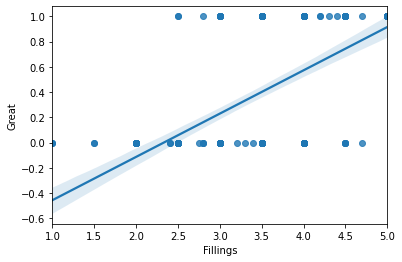

In [144]:
import seaborn as sns
sns.regplot(x=X_train['Fillings'], y=y_train)

* Logistic Regression

In [145]:
log_model = LogisticRegression()

In [146]:
log_model.fit(X_train_Kbest, y_train)
y_test_pred = log_model.predict(X_test_Kbest)

print('Training Accuracy:', log_model.score(X_train_Kbest, y_train))
print('Validation Accuracy:', log_model.score(X_valid_Kbest, y_valid))
print('Test Accuracy:', log_model.score(X_test_Kbest, y_test))

y_test_pred[:10]


Training Accuracy: 0.8859060402684564
Validation Accuracy: 0.8470588235294118
Test Accuracy: 0.7894736842105263


array([ True,  True, False,  True, False, False,  True,  True,  True,
        True])

## Using pipeline

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

* start from begining and let the pipeline does the ohe 

In [152]:
df1 =wrangle(df, 0.7, ["Burrito"], ["Great"])
train = df1[df["Date"] < mask_2017]
valid = df1[(df["Date"] >= mask_2017) & (df["Date"] < mask_2018)]
test = df1[df["Date"] >= mask_2018]

In [153]:
X_train = train
y_train = X_train.pop("Great")

X_valid = valid
y_valid = X_valid.pop("Great")

X_test = test
y_test = X_test.pop("Great")

In [154]:
X_train.nunique()

Burrito          5
Cost            80
Hunger          22
Length          25
Circum          26
Volume          54
Tortilla        16
Temp            17
Meat            20
Fillings        19
Meat:filling    23
Uniformity      18
Salsa           21
Synergy         23
Wrap            16
dtype: int64

In [155]:
X_train.describe(exclude='number')

,Burrito
count,298
unique,5
top,California
freq,118


In [156]:
# Instantiate pipeline with steps
logR_pipe = Pipeline([
                      ('ohe', OneHotEncoder(cols=["Burrito"])),
                      ('imputer', SimpleImputer()),
                      ('logR', LogisticRegression())

])

In [157]:
# Fit model on training data
logR_pipe.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(cols=['Burrito'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logR',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                  

In [158]:
#metric (accuracy) on test set
print('Training Accuracy:', logR_pipe.score(X_train, y_train))
print('Validation Accuracy:', logR_pipe.score(X_valid, y_valid))
print('Test Accuracy:', logR_pipe.score(X_test, y_test))

Training Accuracy: 0.8825503355704698
Validation Accuracy: 0.8117647058823529
Test Accuracy: 0.7894736842105263


In [159]:
y_test_pred = logR_pipe.predict(X_test)
print(y_test_pred[:10])

[ True  True False  True False False  True  True False  True]


In [160]:
logR_pipe.predict_proba(X_valid)[:10]

array([[4.49549461e-01, 5.50450539e-01],
       [6.37851282e-01, 3.62148718e-01],
       [3.30591138e-01, 6.69408862e-01],
       [4.40354384e-01, 5.59645616e-01],
       [9.99747733e-01, 2.52267236e-04],
       [9.68838775e-01, 3.11612249e-02],
       [1.30149104e-01, 8.69850896e-01],
       [3.71203774e-01, 6.28796226e-01],
       [9.99028512e-01, 9.71488344e-04],
       [9.65926792e-02, 9.03407321e-01]])